In [3]:
from read_mem import *
import matplotlib.pyplot as plt
import pathlib
from parse import parse

Total number of log files 3
/home/bastian/D1/registration/mrislurm/438008.out
-- srun: error: n003: task 115: Killed

/home/bastian/D1/registration/mrislurm/438008_log_python_srun.txt E70A0.01LBFGS70
/home/bastian/D1/registration/mrislurm/438009.out
-- srun: error: n004: task 49: Killed

/home/bastian/D1/registration/mrislurm/438009_log_python_srun.txt E70A0.01LBFGS70C4
/home/bastian/D1/registration/mrislurm/438153_log_python_srun.txt 
 probably still running init? Continue.


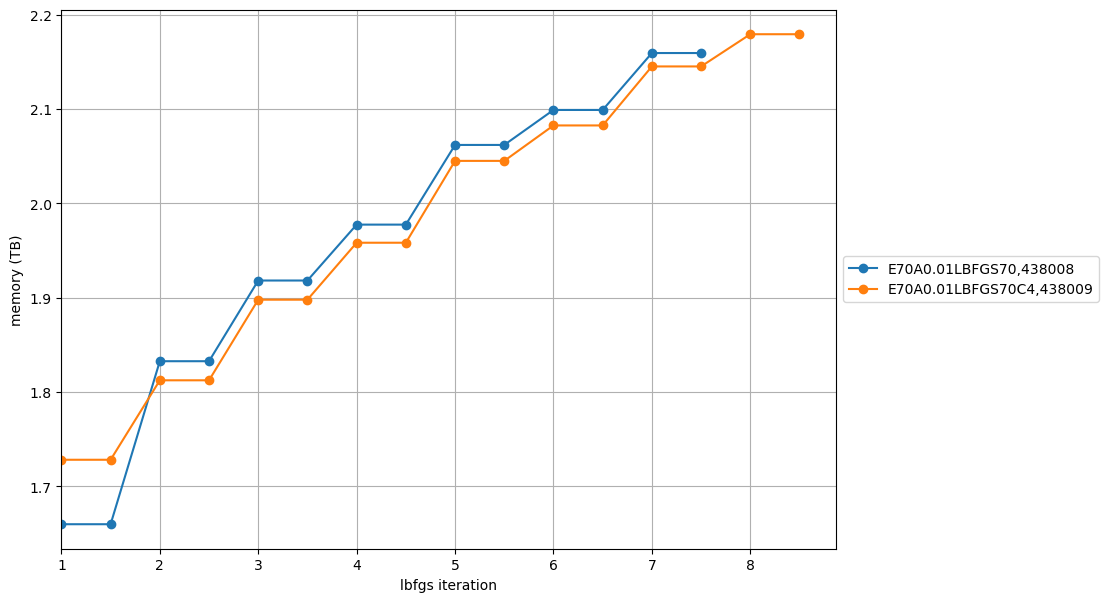

In [6]:
# filenames = ["/home/bastian/D1/registration/mrislurm/436844_log_python_srun.txt"]


# path = pathlib.Path("/home/bastian/D1/registration/cubeslurm/")
# # slurmids = list(range(437522, 437526))
# # slurmids = list(range(437534, 437543))
# # slurmids.remove(437537)
# slurmids = list(range(437543, 437559))
# slurmids.remove(437547)

# slurmids += list(range(437573, 437576))
# slurmids += list(range(437579, 437585))
# slurmids += list(range(437579, 437588))
# slurmids += list(range(437590, 437591))

# slurmids.remove(437585)
# slurmids.remove(437586)

# slurmids = set(slurmids)

# slurmids = [# 437606, 
#             437649, 437650, 437653, 437657, 437707, 437711, 437712]

# slurmids = [437738, 437739, 437740, 437762, 437768,437771,]


path = pathlib.Path("/home/bastian/D1/registration/mrislurm/")
slurmids = [# 437776, 437782, 437847, 
            # 437912, 437913, 437915,437918,437919,437920,437921,
            #437783, 437866
            438008, 438009, 438153, 438155
            ]

print("Total number of log files", len(slurmids))

fig = plt.figure(figsize=(10,7))
ax = plt.subplot(111)

colors = {1: "darkblue", 2: "blue", 4:"deepskyblue", 8:"slategrey", 10: "k"}

for slurmid in slurmids:

    filename = path / (str(slurmid) + "_log_python_srun.txt")

    mema, outfoldername = read_memory(filename)



    check_for_error(path / (str(slurmid) + ".out"))
    check(filename)#path / (str(slurmid) + ".out"))

    # ntasks, maxcor, meshn = read(path / (str(slurmid) + ".out"))

    outfoldername = outfoldername.replace("\n", "").replace(" ", "")
    
    print(filename, outfoldername)
    try:
        mema[:,0]
        # print(mema[:, 0])
    except IndexError:
        print(outfoldername, "probably still running init? Continue.")
        continue

    marker = "o"
    linestyle = "-"

    # if outfoldername is not None and len(outfoldername) > 0:
    #     res = parse("{}NC{}_{}", outfoldername)
    #     nc = res[1]
    #     color = colors[int(nc)]
    # else:
    #     nc= 42
    #     color = "red"

    if "self" in outfoldername:
        marker = "d"

    if "NOSMOOTHEN" in outfoldername:
        marker = "x"
    elif "preconditioning" in outfoldername:
        linestyle = "-"
        marker = "s"

    if "nol2" in outfoldername:
        marker = "x"
        linestyle = "--"
    if "CG" in outfoldername:
        marker = "d"
        linestyle = ":"

    elif "projector" in outfoldername:
        marker = "*"
        linestyle = ":"


    fac = 1
    # fac = mema[0,1]
    
    plt.plot(mema[:,0], mema[:,1] / fac, marker=marker, 
            # color=color, linestyle=linestyle, 
            # label="maxcor="+res[1] + "," + res[2].replace("none", "no preconditioning").replace("preconditioning_nosmoothen", "preconditioning = nosmoothen"), 
            label=outfoldername + "," + str(slurmid),
            # label="ntasks=" + str(ntasks).replace("\n", "") + ", maxcor=" + str(maxcor).replace("\n", "")+ ", ncells=" + str(meshn).replace("\n", "")
            # label=slurmid,
            )
    plt.legend()

plt.xlabel("lbfgs iteration")
if fac == 1:
    plt.ylabel("memory (TB)")
else:    
    plt.ylabel("Increase in memory after first iteration")
plt.xlim(1, None)
# plt.yticks([1 + x /1000 for x in range(0, 22, 2)])
plt.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()